# Data Split

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import random
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
from torch.optim import lr_scheduler
import torchvision.models as models


# ----------------------------------------------------------------------------------------------
# Augmentation
# Define data augmentation transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),  # Randomly rotate the image up to 30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust color
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random affine transformation
    transforms.RandomPerspective(),  # Random perspective transformation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random resized crop
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    # transforms.Normalize(mean=[0.485], std=[0.229]) # gray scale, channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image to RGB
])

dataset = ImageFolder(root='/local/data1/honzh073/centralized_learning/data/8bit_dataset', transform=transform)

# ----------------------------------------------------------------------------------------------
# Random seed
seed = 123
random.seed(seed)
torch.manual_seed(seed)

# Split dataset into 80% train, 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(seed))

# DataLoader for training and testing
batch_size = 64

# Move train_loader and test_loader to GPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# ----------------------------------------------------------------------------------------------
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
    device = torch.device("cuda:0") # we have GPU 0, 1
else:
    print("CUDA is not available.")
    device = torch.device("cpu")
# ----------------------------------------------------------------------------------------------
print('done!')


CUDA is available!
done!


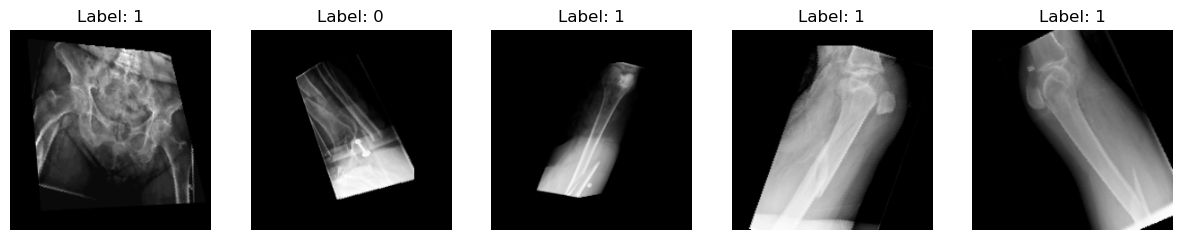

In [3]:
# ---------------------------------------------------------------------------------
# Get some random indices from the training dataset
random_indices = np.random.choice(len(train_dataset), 5, replace=False)

# Plot images (transformed)
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    image, label = train_dataset[idx]
    plt.subplot(1, 5, i + 1)
    plt.title(f"Label: {label}")
    # plt.imshow(image[0])  # 3-channel (RGB)
    plt.imshow(image[0], cmap='gray')  #single-channel (grayscale)
    plt.axis('off')
plt.show()


# Calculate Class Weights

In [4]:
# ---------------------------------------------------------------------------------
# aff and nff numbers in training dataset
train_aff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 AFF
train_nff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 NFF

# aff and nff numbers in test dataset
test_aff_count = sum(1 for _, label in test_dataset if label == 0)
test_nff_count = sum(1 for _, label in test_dataset if label == 1)

print(f"train aff number: {train_aff_count}")
print(f"train nff number: {train_nff_count}")
print(f"test aff number: {test_aff_count}")
print(f"test nff number: {test_nff_count}")

# ---------------------------------------------------------------------------------
# Calculate class weights
n_aff_train = train_aff_count
n_nff_train = train_nff_count

class_weight_aff = 1 / (2 * (n_aff_train / (n_aff_train + n_nff_train)))
class_weight_nff = 1 / (2 * (n_nff_train / (n_aff_train + n_nff_train)))

print(f"Class Weight for AFF (0): {class_weight_aff:.4f}")
print(f"Class Weight for NFF (1): {class_weight_nff:.4f}")


train aff number: 689
train nff number: 2784
test aff number: 179
test nff number: 690
Class Weight for AFF (0): 2.5203
Class Weight for NFF (1): 0.6237


In [5]:
# class_weight_aff = 2.5203
# class_weight_nff = 0.6237

# Before the Train Test

In [6]:
from torch.optim import lr_scheduler
from torchvision.models import resnet152, ResNet152_Weights

# Move class weights to the selected device
class_weights = torch.Tensor([class_weight_aff, class_weight_nff]).to(device)

# ResNet18
model = models.resnet152(weights=ResNet152_Weights.DEFAULT).to(device)

# Update the output layer
model.fc = nn.Linear(2048, 2)  # output layer classes number = dataset classes number
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# training and test
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        # Move images and labels to the selected device
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # Move images and labels to the selected device
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Test_Accuracy: {accuracy:.2f}%")

# optimizer = optim.Adam(model.parameters(), lr=0.00001)


Epoch 1/10, Test_Accuracy: 20.60%
Epoch 2/10, Test_Accuracy: 20.60%
Epoch 3/10, Test_Accuracy: 79.40%
Epoch 4/10, Test_Accuracy: 20.37%
Epoch 5/10, Test_Accuracy: 79.17%
Epoch 6/10, Test_Accuracy: 26.35%
Epoch 7/10, Test_Accuracy: 73.30%
Epoch 8/10, Test_Accuracy: 64.21%
Epoch 9/10, Test_Accuracy: 62.03%
Epoch 10/10, Test_Accuracy: 79.40%


# ResNet18

Epoch 1/50, Train Loss: 0.6347, Test Loss: 0.8054, Train Acc: 50.65%, Test Acc: 74.22%
Epoch 2/50, Train Loss: 0.9248, Test Loss: 0.7515, Train Acc: 51.80%, Test Acc: 79.40%
Epoch 3/50, Train Loss: 0.6093, Test Loss: 0.7111, Train Acc: 52.75%, Test Acc: 41.08%
Epoch 4/50, Train Loss: 0.6696, Test Loss: 0.7312, Train Acc: 50.10%, Test Acc: 79.40%
Epoch 5/50, Train Loss: 0.7010, Test Loss: 0.6866, Train Acc: 55.02%, Test Acc: 51.44%
Epoch 6/50, Train Loss: 0.6506, Test Loss: 0.7727, Train Acc: 52.66%, Test Acc: 78.83%
Epoch 7/50, Train Loss: 0.8156, Test Loss: 0.7209, Train Acc: 56.52%, Test Acc: 79.40%
Epoch 8/50, Train Loss: 0.8196, Test Loss: 0.7144, Train Acc: 52.03%, Test Acc: 75.60%
Epoch 9/50, Train Loss: 0.7511, Test Loss: 0.7025, Train Acc: 58.59%, Test Acc: 79.40%
Epoch 10/50, Train Loss: 0.6498, Test Loss: 0.6939, Train Acc: 55.69%, Test Acc: 78.94%
Epoch 11/50, Train Loss: 0.6510, Test Loss: 0.7026, Train Acc: 55.57%, Test Acc: 22.32%
Epoch 12/50, Train Loss: 0.6272, Test Los

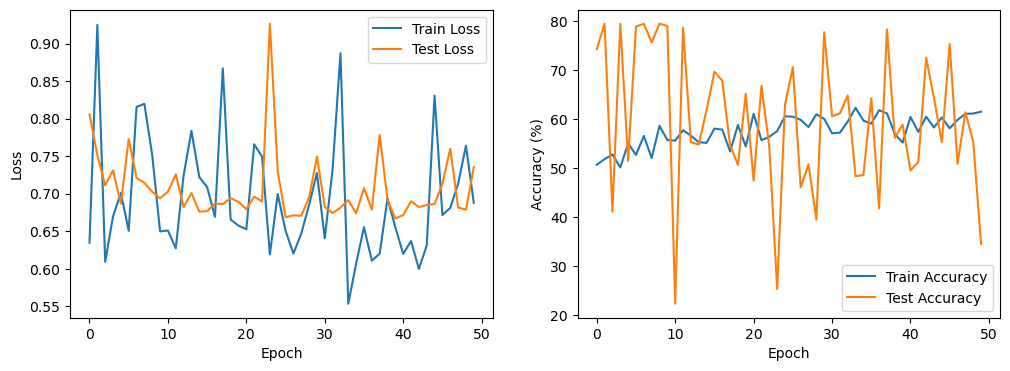

In [7]:
from torchvision.models import resnet18, ResNet18_Weights

# settings
lr = 0.01
step_size = 10
gamma = 0.1

# Move class weights to the selected device
class_weights = [class_weight_aff, class_weight_nff]
class_weights = torch.Tensor(class_weights).to(device)

# ResNet18
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(512, 2)  # output layer classes number = dataset classes number
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


# training and test
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    correct_train = 0  # Correct predictions during training
    total_train = 0    # Total examples during training
    
    for images, labels in train_loader:
        # Move images and labels to the selected device
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy within this batch
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train  # Calculate training accuracy

    model.eval()
    correct_test = 0   # Correct predictions during testing
    total_test = 0     # Total examples during testing
    test_loss = 0      # Variable to store test loss
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_loss += criterion(outputs, labels).item()  # Accumulate test loss

    # Calculate test accuracy
    test_accuracy = 100 * correct_test / total_test

    # Calculate average test loss
    test_loss /= len(test_loader)

    # Record training and test loss and accuracy
    train_losses.append(loss.item())
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")

# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)


In [8]:
# Save the trained VGG model
# # torch.save(model.state_dict(), 'resnet18_xray_classifier.pth')


# ResNet50


Epoch 1/50, Train Loss: 0.5154, Test Loss: 0.8200, Train Acc: 57.50%, Test Acc: 82.05%
Epoch 2/50, Train Loss: 0.5229, Test Loss: 0.8834, Train Acc: 72.88%, Test Acc: 43.84%
Epoch 3/50, Train Loss: 0.5767, Test Loss: 0.6346, Train Acc: 76.27%, Test Acc: 83.31%
Epoch 4/50, Train Loss: 0.3085, Test Loss: 0.5835, Train Acc: 80.16%, Test Acc: 84.23%
Epoch 5/50, Train Loss: 0.4707, Test Loss: 0.5566, Train Acc: 80.33%, Test Acc: 82.51%
Epoch 6/50, Train Loss: 0.4609, Test Loss: 0.4757, Train Acc: 79.61%, Test Acc: 79.52%
Epoch 7/50, Train Loss: 0.7108, Test Loss: 0.5875, Train Acc: 81.54%, Test Acc: 84.70%
Epoch 8/50, Train Loss: 0.2432, Test Loss: 0.4910, Train Acc: 82.72%, Test Acc: 78.25%
Epoch 9/50, Train Loss: 0.6199, Test Loss: 0.6595, Train Acc: 83.07%, Test Acc: 61.68%
Epoch 10/50, Train Loss: 0.2142, Test Loss: 0.5343, Train Acc: 84.05%, Test Acc: 68.12%
Epoch 11/50, Train Loss: 0.4139, Test Loss: 0.4494, Train Acc: 84.34%, Test Acc: 82.97%
Epoch 12/50, Train Loss: 0.2604, Test Los

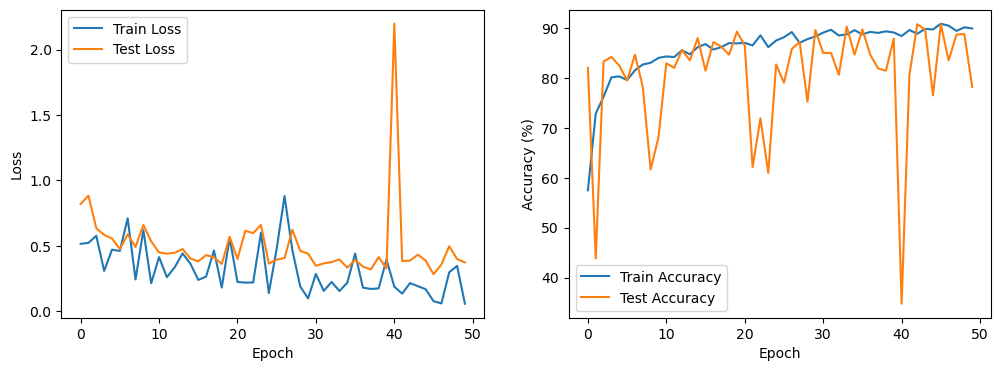

In [9]:
from torchvision.models import resnet50, ResNet50_Weights

# settings
lr = 0.001
step_size = 10
gamma = 0.1

# Move class weights to the selected device
class_weights = [class_weight_aff, class_weight_nff]
class_weights = torch.Tensor(class_weights).to(device)

# ResNet18
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Move the model to the selected device
model = model.to(device)

# Update the output layer
model.fc = nn.Linear(2048, 2)  # output layer classes number = dataset classes number

# Move the model and loss function to the selected device
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Move the loss function to the selected device
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


# training and test
# Lists to store loss and accuracy values
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    correct_train = 0  # Correct predictions during training
    total_train = 0    # Total examples during training
    
    for images, labels in train_loader:
        # Move images and labels to the selected device
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy within this batch
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train  # Calculate training accuracy

    model.eval()
    correct_test = 0   # Correct predictions during testing
    total_test = 0     # Total examples during testing
    test_loss = 0      # Variable to store test loss
    
    with torch.no_grad():
        for images, labels in test_loader:
            # Move images and labels to the selected device
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_loss += criterion(outputs, labels).item()  # Accumulate test loss

    # Calculate test accuracy
    test_accuracy = 100 * correct_test / total_test

    # Calculate average test loss
    test_loss /= len(test_loader)

    # Record training and test loss and accuracy
    train_losses.append(loss.item())
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")

# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# resNet50, Adam(model.parameters(), lr=0.00001)

In [10]:
# Save the trained VGG model
# # torch.save(model.state_dict(), 'resnet50_xray_classifier.pth')


# ResNet152

Epoch 1/50, Train Loss: 0.8079, Test Loss: 1.1464, Train Acc: 62.94%, Test Acc: 79.40%
Epoch 2/50, Train Loss: 1.3125, Test Loss: 0.8007, Train Acc: 79.30%, Test Acc: 67.66%
Epoch 3/50, Train Loss: 0.2878, Test Loss: 0.6277, Train Acc: 79.93%, Test Acc: 77.68%
Epoch 4/50, Train Loss: 0.3731, Test Loss: 0.5122, Train Acc: 81.89%, Test Acc: 78.48%
Epoch 5/50, Train Loss: 0.4124, Test Loss: 0.4983, Train Acc: 84.88%, Test Acc: 85.73%
Epoch 6/50, Train Loss: 0.3811, Test Loss: 0.4765, Train Acc: 83.16%, Test Acc: 78.94%
Epoch 7/50, Train Loss: 0.4759, Test Loss: 0.4591, Train Acc: 85.20%, Test Acc: 85.16%
Epoch 8/50, Train Loss: 0.5780, Test Loss: 0.4699, Train Acc: 85.20%, Test Acc: 67.20%
Epoch 9/50, Train Loss: 0.3581, Test Loss: 0.4279, Train Acc: 85.83%, Test Acc: 84.93%
Epoch 10/50, Train Loss: 0.3213, Test Loss: 0.4958, Train Acc: 84.57%, Test Acc: 87.46%
Epoch 11/50, Train Loss: 0.7474, Test Loss: 0.3536, Train Acc: 85.75%, Test Acc: 86.54%
Epoch 12/50, Train Loss: 0.3917, Test Los

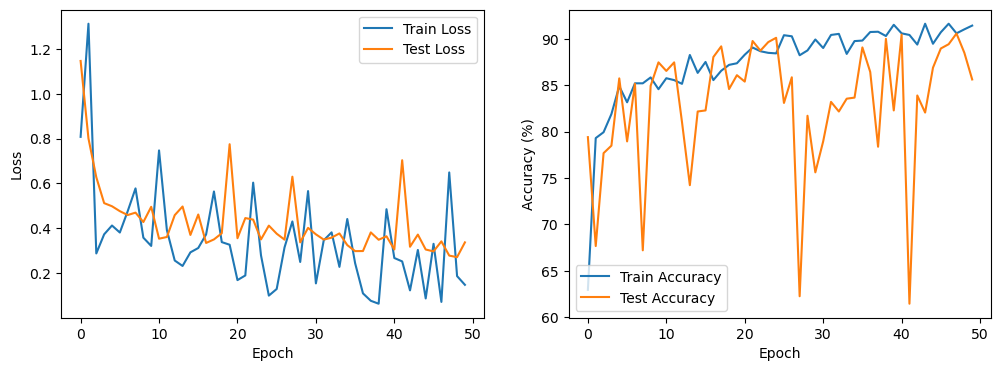

In [11]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import random
import matplotlib.pyplot as plt  # Import Matplotlib for plotting
from torchvision.models import resnet152, ResNet152_Weights

# settings
lr = 0.001
step_size = 10
gamma = 0.1

# Move class weights to the selected device
class_weights = [class_weight_aff, class_weight_nff]
class_weights = torch.Tensor(class_weights).to(device)

# ResNet18
model = models.resnet152(weights=ResNet152_Weights.DEFAULT)
model = model.to(device)

# Update the output layer
model.fc = nn.Linear(2048, 2)  # output layer classes number = dataset classes number
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# training and test
# Lists to store loss and accuracy values
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    correct_train = 0  # Correct predictions during training
    total_train = 0    # Total examples during training
    
    for images, labels in train_loader:
        # Move images and labels to the selected device
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy within this batch
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train  # Calculate training accuracy

    model.eval()
    correct_test = 0   # Correct predictions during testing
    total_test = 0     # Total examples during testing
    test_loss = 0      # Variable to store test loss
    
    with torch.no_grad():
        for images, labels in test_loader:
            # Move images and labels to the selected device
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_loss += criterion(outputs, labels).item()  # Accumulate test loss

    # Calculate test accuracy
    test_accuracy = 100 * correct_test / total_test

    # Calculate average test loss
    test_loss /= len(test_loader)

    # Record training and test loss and accuracy
    train_losses.append(loss.item())
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")

# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# resNet50, Adam(model.parameters(), lr=0.00001)

In [12]:
# Save the trained VGG model
# # torch.save(model.state_dict(), 'resnet152_xray_classifier.pth')


# VGG19 large deep network

Epoch 1/50, Train Loss: 0.5943, Test Loss: 1.0072, Train Acc: 52.15%, Test Acc: 79.40%
Epoch 2/50, Train Loss: 0.6971, Test Loss: 0.7153, Train Acc: 47.08%, Test Acc: 79.40%
Epoch 3/50, Train Loss: 0.7574, Test Loss: 0.6982, Train Acc: 59.83%, Test Acc: 20.60%
Epoch 4/50, Train Loss: 0.6627, Test Loss: 0.7008, Train Acc: 51.37%, Test Acc: 79.40%
Epoch 5/50, Train Loss: 0.7199, Test Loss: 0.6942, Train Acc: 49.84%, Test Acc: 79.40%
Epoch 6/50, Train Loss: 0.6811, Test Loss: 0.6951, Train Acc: 55.63%, Test Acc: 79.40%
Epoch 7/50, Train Loss: 0.6987, Test Loss: 0.6931, Train Acc: 48.00%, Test Acc: 20.60%
Epoch 8/50, Train Loss: 0.7137, Test Loss: 0.6951, Train Acc: 53.61%, Test Acc: 79.40%
Epoch 9/50, Train Loss: 0.6861, Test Loss: 0.6942, Train Acc: 49.06%, Test Acc: 79.40%
Epoch 10/50, Train Loss: 0.7030, Test Loss: 0.6932, Train Acc: 56.03%, Test Acc: 20.60%
Epoch 11/50, Train Loss: 0.6988, Test Loss: 0.6942, Train Acc: 47.31%, Test Acc: 79.40%
Epoch 12/50, Train Loss: 0.7071, Test Los

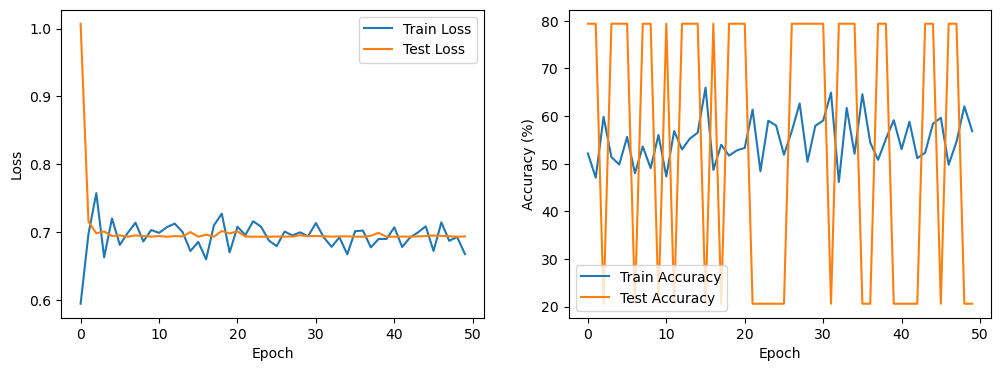

In [13]:

from torchvision.models import vgg19, VGG19_Weights

# Move class weights to the selected device
class_weights = [class_weight_aff, class_weight_nff]
class_weights = torch.Tensor(class_weights).to(device)

# VGG19
model = models.vgg19(weights=VGG19_Weights.DEFAULT)

# Modify the classifier part for your specific number of classes
model.classifier[6] = nn.Linear(4096, 2)  # output layer classes number = dataset classes number

# Move the model to the selected device
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Move the loss function to the selected device
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# training and test
# Lists to store loss and accuracy values
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    correct_train = 0  # Correct predictions during training
    total_train = 0    # Total examples during training
    
    for images, labels in train_loader:
        # Move images and labels to the selected device
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy within this batch
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train  # Calculate training accuracy

    model.eval()
    correct_test = 0   # Correct predictions during testing
    total_test = 0     # Total examples during testing
    test_loss = 0      # Variable to store test loss
    
    with torch.no_grad():
        for images, labels in test_loader:
            # Move images and labels to the selected device
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_loss += criterion(outputs, labels).item()  # Accumulate test loss

    # Calculate test accuracy
    test_accuracy = 100 * correct_test / total_test

    # Calculate average test loss
    test_loss /= len(test_loader)

    # Record training and test loss and accuracy
    train_losses.append(loss.item())
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")

# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# weights=VGG19_Weights.DEFAULT
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)



# Save VGG model

In [14]:
# Save model
# # torch.save(model.state_dict(), 'vgg19_xray_classifier.pth')


# Resnet152 5-fold

CUDA is available!
Fold 1/5
Epoch 1/25, Train Loss: 0.7296, Test Loss: 0.7591, Train Acc: 67.41%, Test Acc: 50.98%
Epoch 2/25, Train Loss: 0.7008, Test Loss: 0.6415, Train Acc: 60.06%, Test Acc: 52.70%
Epoch 3/25, Train Loss: 0.6847, Test Loss: 0.8660, Train Acc: 54.56%, Test Acc: 36.94%
Epoch 4/25, Train Loss: 0.7258, Test Loss: 0.8290, Train Acc: 59.49%, Test Acc: 56.16%
Epoch 5/25, Train Loss: 0.3423, Test Loss: 0.6470, Train Acc: 73.91%, Test Acc: 76.87%
Epoch 6/25, Train Loss: 0.5752, Test Loss: 0.4551, Train Acc: 79.93%, Test Acc: 82.85%
Epoch 7/25, Train Loss: 0.5928, Test Loss: 0.7320, Train Acc: 78.75%, Test Acc: 76.52%
Epoch 8/25, Train Loss: 0.5265, Test Loss: 0.5196, Train Acc: 80.39%, Test Acc: 78.37%
Epoch 9/25, Train Loss: 0.3615, Test Loss: 0.4984, Train Acc: 83.65%, Test Acc: 82.74%
Epoch 10/25, Train Loss: 0.3179, Test Loss: 0.8567, Train Acc: 83.44%, Test Acc: 60.64%
Epoch 11/25, Train Loss: 0.3095, Test Loss: 0.3728, Train Acc: 81.98%, Test Acc: 86.65%
Epoch 12/25, 

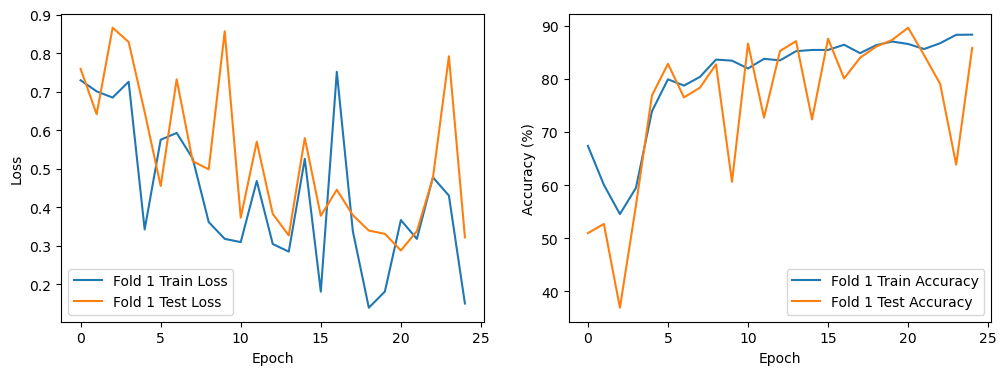

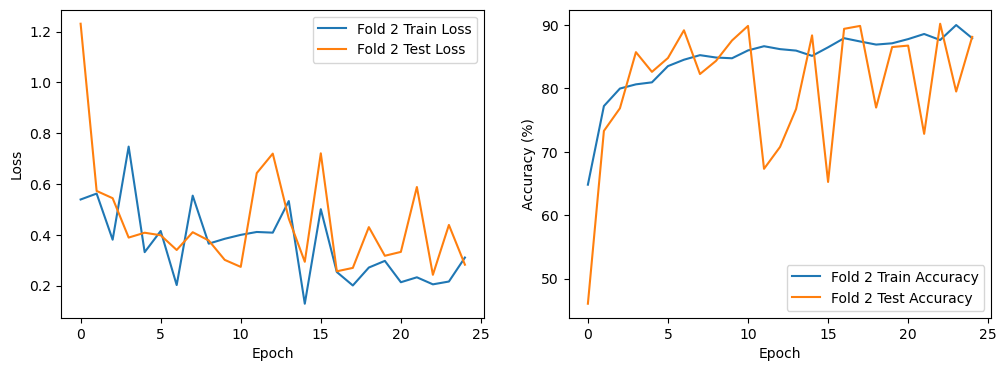

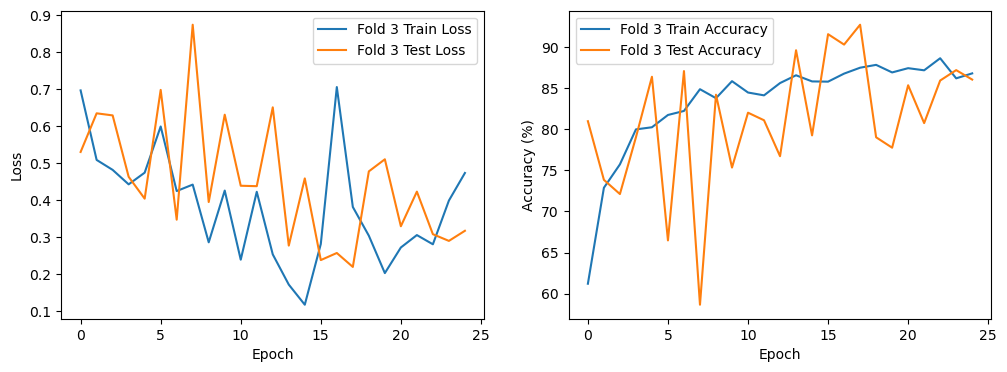

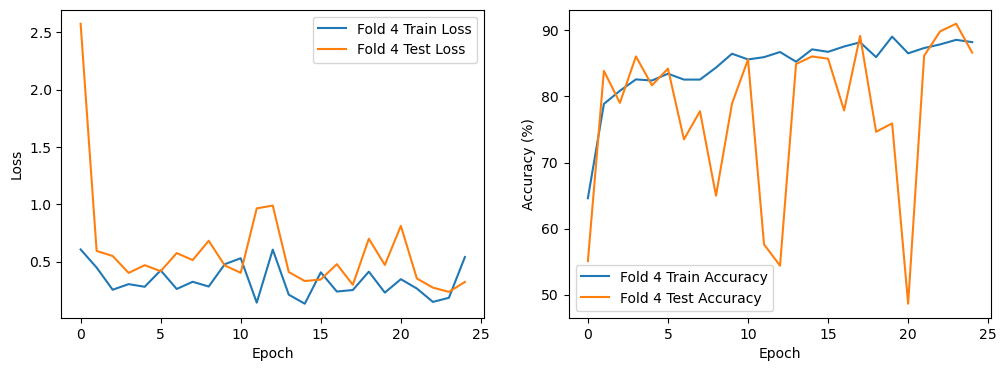

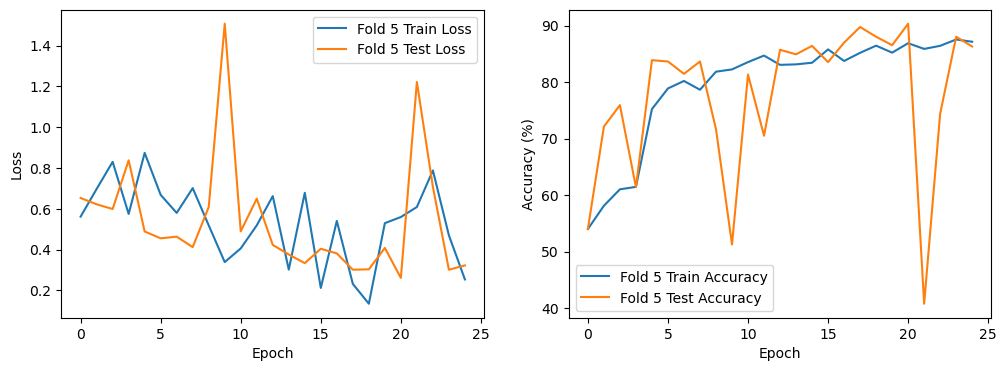

In [15]:
from sklearn.model_selection import KFold  # Import KFold for cross-validation
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
import random
import matplotlib.pyplot as plt  # Import Matplotlib for plotting
from torchvision.models import resnet152, ResNet152_Weights

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
    device = torch.device("cuda:0")
else:
    print("CUDA is not available.")
    device = torch.device("cpu")

# Move class weights to the selected device
class_weights = [class_weight_aff, class_weight_nff]
class_weights = torch.Tensor(class_weights).to(device)

# Define the number of folds for cross-validation
num_folds = 5

# Create a KFold object to split the dataset
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store accuracy and loss values for each fold
fold_train_accuracies = []
fold_test_accuracies = []
fold_train_losses = []
fold_test_losses = []

for fold, (train_indices, test_indices) in enumerate(kf.split(dataset)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split the dataset into train and test sets for this fold
    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)

    # Create data loaders for train and test sets
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # ResNet152
    model = models.resnet152(weights=ResNet152_Weights.DEFAULT)

    # Update the output layer
    model.fc = nn.Linear(2048, 2)  # output layer classes number = dataset classes number
    model = model.to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = criterion.to(device)

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Lists to store loss and accuracy values
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    num_epochs = 25
    for epoch in range(num_epochs):
        model.train()
        correct_train = 0  # Correct predictions during training
        total_train = 0    # Total examples during training

        for images, labels in train_loader:
            # Move images and labels to the selected device
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training accuracy within this batch
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train  # Calculate training accuracy

        model.eval()
        correct_test = 0   # Correct predictions during testing
        total_test = 0     # Total examples during testing
        test_loss = 0      # Variable to store test loss

        with torch.no_grad():
            for images, labels in test_loader:
                # Move images and labels to the selected device
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                test_loss += criterion(outputs, labels).item()  # Accumulate test loss

        # Calculate test accuracy
        test_accuracy = 100 * correct_test / total_test

        # Calculate average test loss
        test_loss /= len(test_loader)

        # Record training and test loss and accuracy
        train_losses.append(loss.item())
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")

    # Append the accuracy and loss values for this fold to the respective lists
    fold_train_accuracies.append(train_accuracies)
    fold_test_accuracies.append(test_accuracies)
    fold_train_losses.append(train_losses)
    fold_test_losses.append(test_losses)

# Plot loss and accuracy for each fold
for fold in range(num_folds):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(fold_train_losses[fold], label=f'Fold {fold + 1} Train Loss')
    plt.plot(fold_test_losses[fold], label=f'Fold {fold + 1} Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(fold_train_accuracies[fold], label=f'Fold {fold + 1} Train Accuracy')
    plt.plot(fold_test_accuracies[fold], label=f'Fold {fold + 1} Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

plt.show()


In [16]:
# Save the trained VGG model
# # torch.save(model.state_dict(), '5fold_resnet152_xray_classifier.pth')


# Image Classification Demo

# 5-fold validation VGG

Fold 1/5
Epoch 1/25, Train Loss: 0.7177, Test Loss: 0.6829, Train Acc: 58.19%, Test Acc: 76.64%
Epoch 2/25, Train Loss: 0.6911, Test Loss: 0.7264, Train Acc: 57.04%, Test Acc: 22.67%
Epoch 3/25, Train Loss: 0.6819, Test Loss: 0.6784, Train Acc: 52.23%, Test Acc: 77.33%
Epoch 4/25, Train Loss: 0.6868, Test Loss: 0.7437, Train Acc: 63.63%, Test Acc: 22.67%
Epoch 5/25, Train Loss: 0.7167, Test Loss: 0.6658, Train Acc: 61.76%, Test Acc: 77.33%
Epoch 6/25, Train Loss: 0.6815, Test Loss: 0.6380, Train Acc: 61.22%, Test Acc: 77.33%
Epoch 7/25, Train Loss: 0.6926, Test Loss: 0.6673, Train Acc: 63.92%, Test Acc: 77.33%
Epoch 8/25, Train Loss: 0.6634, Test Loss: 0.6772, Train Acc: 66.40%, Test Acc: 77.33%
Epoch 9/25, Train Loss: 0.6958, Test Loss: 0.7160, Train Acc: 59.17%, Test Acc: 22.67%
Epoch 10/25, Train Loss: 0.6938, Test Loss: 0.7063, Train Acc: 55.80%, Test Acc: 22.67%
Epoch 11/25, Train Loss: 0.6731, Test Loss: 0.7095, Train Acc: 56.95%, Test Acc: 22.67%
Epoch 12/25, Train Loss: 0.7364,

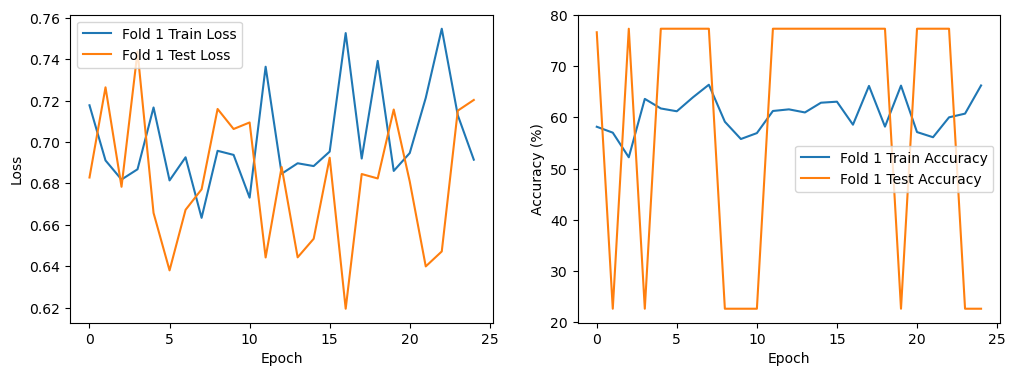

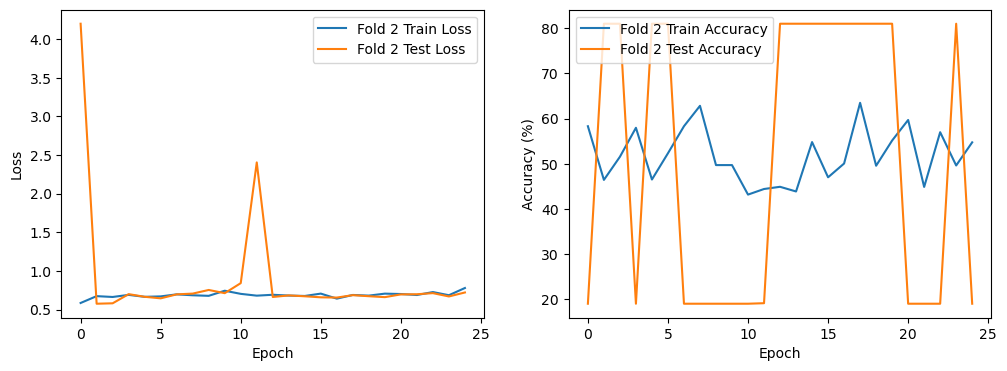

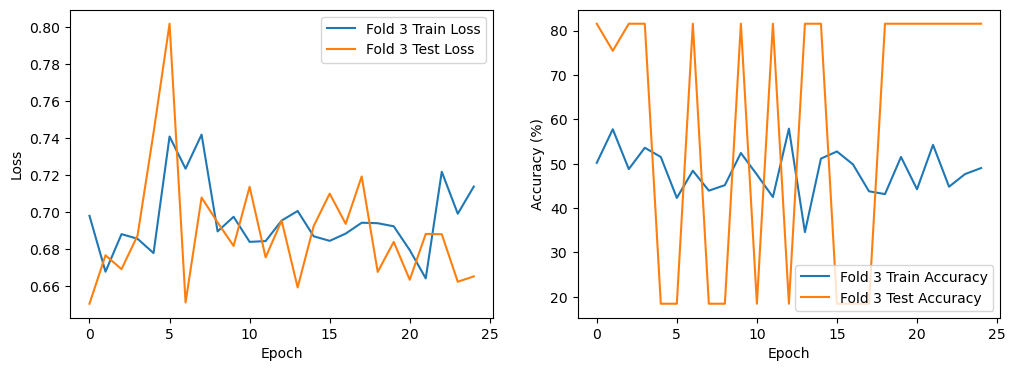

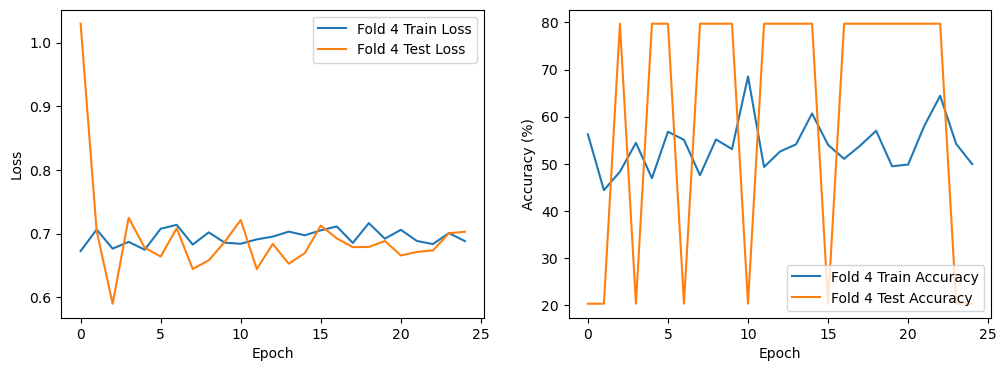

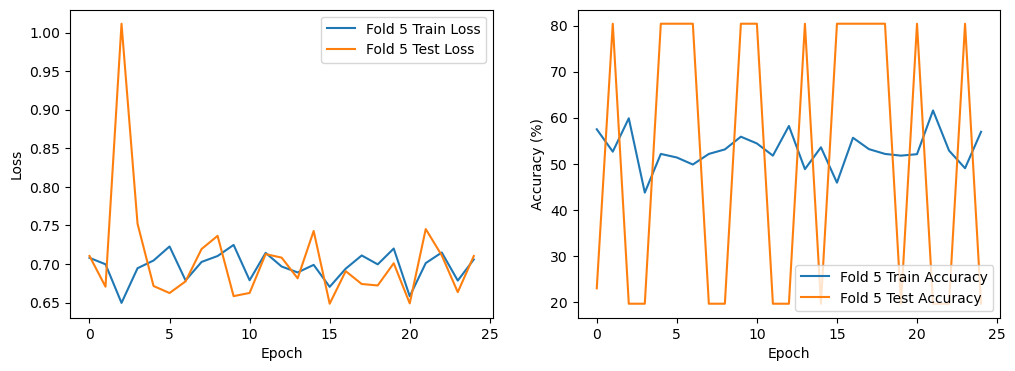

In [17]:
from sklearn.model_selection import KFold  # Import KFold for cross-validation
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
import random
import matplotlib.pyplot as plt  # Import Matplotlib for plotting
from torchvision.models import vgg19, VGG19_Weights

# Define the number of folds for cross-validation
num_folds = 5

# Create a KFold object to split the dataset
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store accuracy and loss values for each fold
fold_train_accuracies = []
fold_test_accuracies = []
fold_train_losses = []
fold_test_losses = []

for fold, (train_indices, test_indices) in enumerate(kf.split(dataset)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split the dataset into train and test sets for this fold
    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)

    # Create data loaders for train and test sets
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # VGG19
    model = models.vgg19(weights=VGG19_Weights.DEFAULT)

    # Modify the classifier part for your specific number of classes
    model.classifier[6] = nn.Linear(4096, 2)  # output layer classes number = dataset classes number
    model = model.to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = criterion.to(device)

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Lists to store loss and accuracy values
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    num_epochs = 25
    for epoch in range(num_epochs):
        model.train()
        correct_train = 0  # Correct predictions during training
        total_train = 0    # Total examples during training

        for images, labels in train_loader:
            # Move images and labels to the selected device
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training accuracy within this batch
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train  # Calculate training accuracy

        model.eval()
        correct_test = 0   # Correct predictions during testing
        total_test = 0     # Total examples during testing
        test_loss = 0      # Variable to store test loss

        with torch.no_grad():
            for images, labels in test_loader:
                # Move images and labels to the selected device
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                test_loss += criterion(outputs, labels).item()  # Accumulate test loss

        # Calculate test accuracy
        test_accuracy = 100 * correct_test / total_test

        # Calculate average test loss
        test_loss /= len(test_loader)

        # Record training and test loss and accuracy
        train_losses.append(loss.item())
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")

    # Append the accuracy and loss values for this fold to the respective lists
    fold_train_accuracies.append(train_accuracies)
    fold_test_accuracies.append(test_accuracies)
    fold_train_losses.append(train_losses)
    fold_test_losses.append(test_losses)

# Plot loss and accuracy for each fold
for fold in range(num_folds):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(fold_train_losses[fold], label=f'Fold {fold + 1} Train Loss')
    plt.plot(fold_test_losses[fold], label=f'Fold {fold + 1} Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(fold_train_accuracies[fold], label=f'Fold {fold + 1} Train Accuracy')
    plt.plot(fold_test_accuracies[fold], label=f'Fold {fold + 1} Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

plt.show()


In [18]:
# Save the trained VGG model
# # torch.save(model.state_dict(), '5fold_vgg19_xray_classifier.pth')
